# Machine Learning Project: Predicting BMI Categories from Height & Weight

## Project Overview
This project aims to predict Body Mass Index (BMI) categories using machine learning techniques based on height and weight measurements. We'll explore the dataset, perform data preprocessing, train multiple classification models, and evaluate their performance.

### BMI Categories:
- **Underweight**: BMI < 18.5
- **Normal weight**: 18.5 ≤ BMI < 25
- **Overweight**: 25 ≤ BMI < 30
- **Obese**: BMI ≥ 30

### Dataset Features:
- Sex (Male/Female)
- Age
- Height (in inches)
- Weight (in pounds)
- BMI (target for category prediction)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Python version:", pd.__version__)

Libraries imported successfully!
Python version: 2.2.2


## 1. Data Loading and Upload

**For Google Colab Users:**
1. Upload your `bmi_data.csv` file using the file upload feature
2. Run the cell below to load the dataset

In [2]:
# For Google Colab: Upload the dataset
from google.colab import files

# Upload the BMI dataset
print("Please upload your bmi_data.csv file:")
uploaded = files.upload()

# Load the dataset
df = pd.read_csv('bmi_data.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Please upload your bmi_data.csv file:


Saving bmi_data.csv to bmi_data.csv
Dataset loaded successfully!
Dataset shape: (25000, 5)

First few rows:


,Sex,Age,Height(Inches),Weight(Pounds),BMI
0,Female,21,65.78331,112.9925,18.357646
1,Female,35,71.51521,136.4873,18.762652
2,Female,27,69.39874,153.0269,22.338985
3,Male,24,68.21660,142.3354,21.504612
4,Female,18,67.78781,144.2971,22.077669


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Basic information about the dataset
print("Dataset Information:")
print("="*50)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
df.describe()

Dataset Information:
Shape: (25000, 5)
Columns: ['Sex', 'Age', 'Height(Inches)', 'Weight(Pounds)', 'BMI']

Data types:
Sex                object
Age                 int64
Height(Inches)    float64
Weight(Pounds)    float64
BMI               float64
dtype: object

Basic statistics:


,Age,Height(Inches),Weight(Pounds),BMI
count,25000.000000,24981.000000,24984.000000,24950.000000
mean,26.499600,67.992968,127.078208,19.321368
std,5.190379,1.901481,11.663043,1.552091
min,18.000000,60.278360,78.014760,13.070879
25%,22.000000,66.704930,119.307775,18.278339
50%,27.000000,67.995920,127.156700,19.302160
75%,31.000000,69.272370,134.894050,20.357547
max,35.000000,75.152800,170.924000,26.023756


Missing Values Analysis:
           Column  Missing_Count  Missing_Percentage
0             Sex              0               0.000
1             Age              0               0.000
2  Height(Inches)             19               0.076
3  Weight(Pounds)             16               0.064
4             BMI             50               0.200


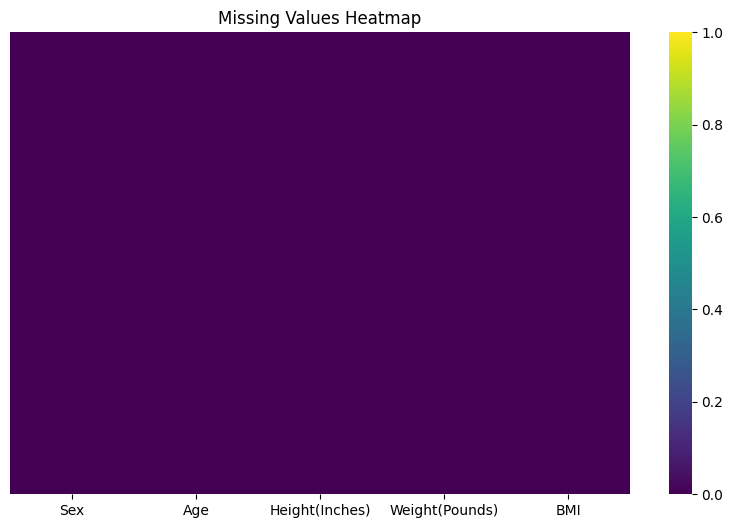

In [4]:
# Check for missing values
print("Missing Values Analysis:")
print("="*50)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})

print(missing_df)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

## 3. Data Preprocessing

In [5]:
# Create a copy for preprocessing
df_clean = df.copy()

# Handle missing values
print("Before cleaning:", df_clean.shape)

# Drop rows with missing BMI values (our target variable)
df_clean = df_clean.dropna(subset=['BMI'])

# For other missing values, we'll use median imputation
df_clean['Height(Inches)'].fillna(df_clean['Height(Inches)'].median(), inplace=True)
df_clean['Weight(Pounds)'].fillna(df_clean['Weight(Pounds)'].median(), inplace=True)
df_clean['Age'].fillna(df_clean['Age'].median(), inplace=True)

print("After cleaning:", df_clean.shape)

# Create BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_clean['BMI_Category'] = df_clean['BMI'].apply(categorize_bmi)

print("\nBMI Category Distribution:")
print(df_clean['BMI_Category'].value_counts())
print("\nPercentage Distribution:")
print(df_clean['BMI_Category'].value_counts(normalize=True) * 100)

Before cleaning: (25000, 5)
After cleaning: (24950, 5)

BMI Category Distribution:
BMI_Category
Normal weight    17513
Underweight       7431
Overweight           6
Name: count, dtype: int64

Percentage Distribution:
BMI_Category
Normal weight    70.192385
Underweight      29.783567
Overweight        0.024048
Name: proportion, dtype: float64


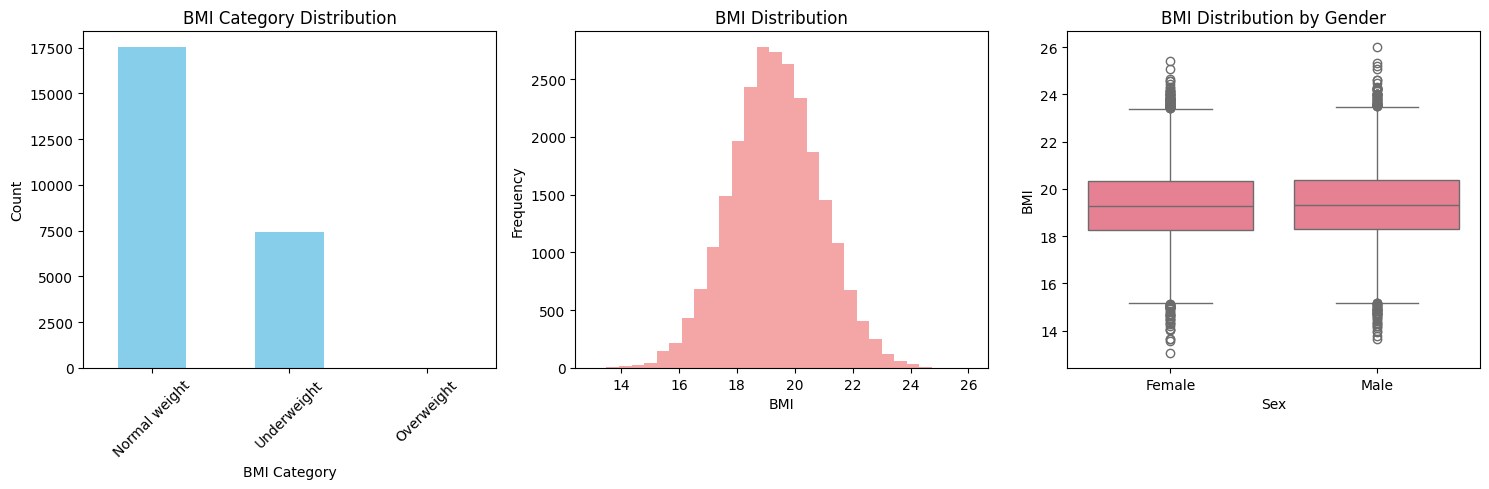

In [6]:
# Visualize BMI category distribution
plt.figure(figsize=(15, 5))

# BMI Category Distribution
plt.subplot(1, 3, 1)
df_clean['BMI_Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('BMI Category Distribution')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# BMI Distribution
plt.subplot(1, 3, 2)
plt.hist(df_clean['BMI'], bins=30, color='lightcoral', alpha=0.7)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')

# BMI by Gender
plt.subplot(1, 3, 3)
sns.boxplot(data=df_clean, x='Sex', y='BMI')
plt.title('BMI Distribution by Gender')

plt.tight_layout()
plt.show()

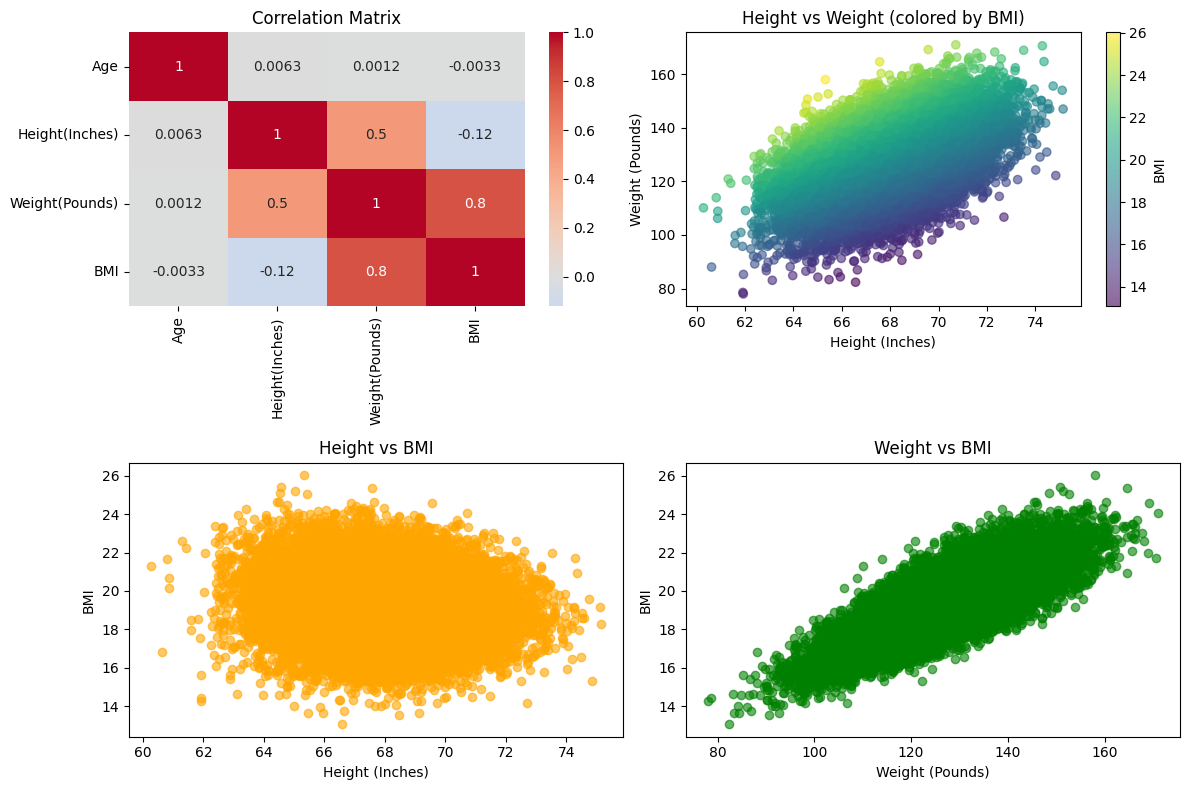

In [7]:
# Correlation analysis
plt.figure(figsize=(12, 8))

# Create correlation heatmap
numeric_cols = ['Age', 'Height(Inches)', 'Weight(Pounds)', 'BMI']
correlation_matrix = df_clean[numeric_cols].corr()

plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

# Scatter plots
plt.subplot(2, 2, 2)
plt.scatter(df_clean['Height(Inches)'], df_clean['Weight(Pounds)'],
           c=df_clean['BMI'], cmap='viridis', alpha=0.6)
plt.colorbar(label='BMI')
plt.xlabel('Height (Inches)')
plt.ylabel('Weight (Pounds)')
plt.title('Height vs Weight (colored by BMI)')

plt.subplot(2, 2, 3)
plt.scatter(df_clean['Height(Inches)'], df_clean['BMI'], alpha=0.6, color='orange')
plt.xlabel('Height (Inches)')
plt.ylabel('BMI')
plt.title('Height vs BMI')

plt.subplot(2, 2, 4)
plt.scatter(df_clean['Weight(Pounds)'], df_clean['BMI'], alpha=0.6, color='green')
plt.xlabel('Weight (Pounds)')
plt.ylabel('BMI')
plt.title('Weight vs BMI')

plt.tight_layout()
plt.show()

## 4. Feature Engineering and Preparation

In [8]:
# Prepare features for machine learning
# Encode categorical variables
label_encoder = LabelEncoder()
df_clean['Sex_encoded'] = label_encoder.fit_transform(df_clean['Sex'])

# Select features (X) and target (y)
X = df_clean[['Sex_encoded', 'Age', 'Height(Inches)', 'Weight(Pounds)']]
y = df_clean['BMI_Category']

print("Features (X):")
print(X.head())
print(f"\nFeature shapes: {X.shape}")

print("\nTarget (y):")
print(y.head())
print(f"Target shape: {y.shape}")

# Encode target variable for machine learning
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\nTarget classes: {target_encoder.classes_}")
print(f"Encoded target sample: {y_encoded[:10]}")

Features (X):
   Sex_encoded  Age  Height(Inches)  Weight(Pounds)
0            0   21        65.78331        112.9925
1            0   35        71.51521        136.4873
2            0   27        69.39874        153.0269
3            1   24        68.21660        142.3354
4            0   18        67.78781        144.2971

Feature shapes: (24950, 4)

Target (y):
0      Underweight
1    Normal weight
2    Normal weight
3    Normal weight
4    Normal weight
Name: BMI_Category, dtype: object
Target shape: (24950,)

Target classes: ['Normal weight' 'Overweight' 'Underweight']
Encoded target sample: [2 0 0 0 0 2 0 2 0 2]


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed!")
print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Scaled testing features shape: {X_test_scaled.shape}")

Training set size: 19960
Testing set size: 4990

Feature scaling completed!
Scaled training features shape: (19960, 4)
Scaled testing features shape: (4990, 4)


## 5. Machine Learning Models

In [10]:
# Initialize multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate models
model_results = {}

print("Training and evaluating models:")
print("="*60)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    if name == 'SVM':
        # Use scaled features for SVM
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Use original features for tree-based models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation score
    if name == 'SVM':
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    model_results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n" + "="*60)
print("Model Comparison Summary:")
for name, results in model_results.items():
    print(f"{name:20} | Accuracy: {results['accuracy']:.4f} | CV: {results['cv_mean']:.4f}")

Training and evaluating models:

Training Logistic Regression...
Logistic Regression Accuracy: 0.9707
Logistic Regression CV Score: 0.9726 (+/- 0.0331)

Training Random Forest...
Random Forest Accuracy: 0.9946
Random Forest CV Score: 0.9929 (+/- 0.0016)

Training Decision Tree...
Decision Tree Accuracy: 0.9922
Decision Tree CV Score: 0.9924 (+/- 0.0018)

Training SVM...
SVM Accuracy: 0.9940
SVM CV Score: 0.9945 (+/- 0.0016)

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.9916
Gradient Boosting CV Score: 0.9902 (+/- 0.0015)

Model Comparison Summary:
Logistic Regression  | Accuracy: 0.9707 | CV: 0.9726
Random Forest        | Accuracy: 0.9946 | CV: 0.9929
Decision Tree        | Accuracy: 0.9922 | CV: 0.9924
SVM                  | Accuracy: 0.9940 | CV: 0.9945
Gradient Boosting    | Accuracy: 0.9916 | CV: 0.9902


## 6. Model Evaluation and Analysis

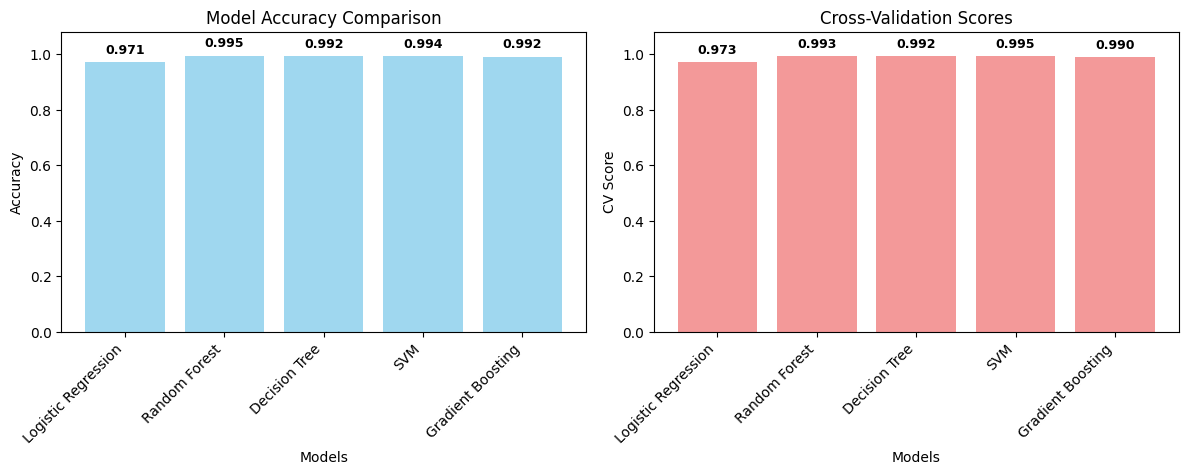


Best performing model: Random Forest
Best accuracy: 0.9946


In [21]:
# Visualize model performance comparison
plt.figure(figsize=(12, 8))

# Model accuracy comparison
model_names = list(model_results.keys())
accuracies = [model_results[name]['accuracy'] for name in model_names]
cv_scores = [model_results[name]['cv_mean'] for name in model_names]

plt.subplot(2, 2, 1)
x_pos = np.arange(len(model_names))
plt.bar(x_pos, accuracies, color='skyblue', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x_pos, model_names, rotation=45, ha='right')
plt.ylim([0, 1.08])

# Add accuracy values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.subplot(2, 2, 2)
plt.bar(x_pos, cv_scores, color='lightcoral', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('CV Score')
plt.title('Cross-Validation Scores')
plt.xticks(x_pos, model_names, rotation=45, ha='right')
plt.ylim([0, 1.08])

# Add CV scores on bars
for i, cv in enumerate(cv_scores):
    plt.text(i, cv + 0.02, f'{cv:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Find the best performing model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
print(f"\nBest performing model: {best_model_name}")
print(f"Best accuracy: {model_results[best_model_name]['accuracy']:.4f}")

Detailed Classification Report for Random Forest:
               precision    recall  f1-score   support

Normal weight       1.00      1.00      1.00      3503
   Overweight       0.00      0.00      0.00         1
  Underweight       0.99      0.99      0.99      1486

     accuracy                           0.99      4990
    macro avg       0.66      0.66      0.66      4990
 weighted avg       0.99      0.99      0.99      4990



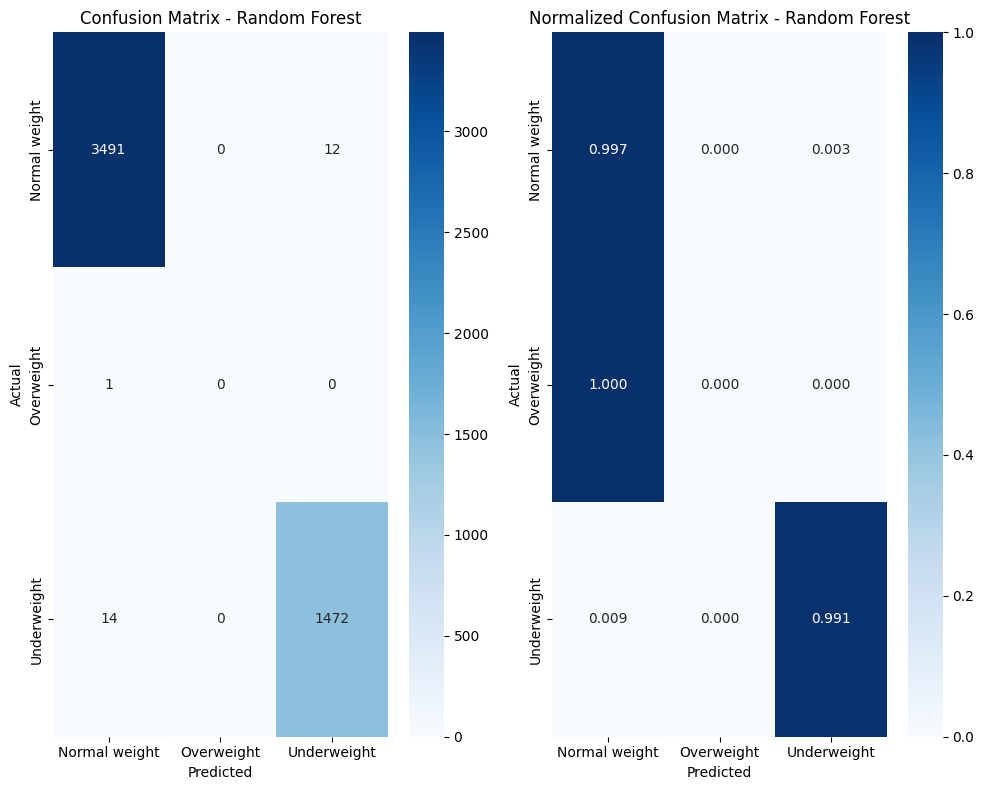

In [12]:
# Detailed evaluation of the best model
best_predictions = model_results[best_model_name]['predictions']

# Classification report
print(f"Detailed Classification Report for {best_model_name}:")
print("="*70)
class_names = target_encoder.classes_
print(classification_report(y_test, best_predictions, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_predictions)

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Normalized confusion matrix
cm_normalized = confusion_matrix(y_test, best_predictions, normalize='true')
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Normalized Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

Feature Importance for Random Forest:
          feature  importance
3  Weight(Pounds)    0.726656
2  Height(Inches)    0.265603
1             Age    0.006540
0             Sex    0.001201


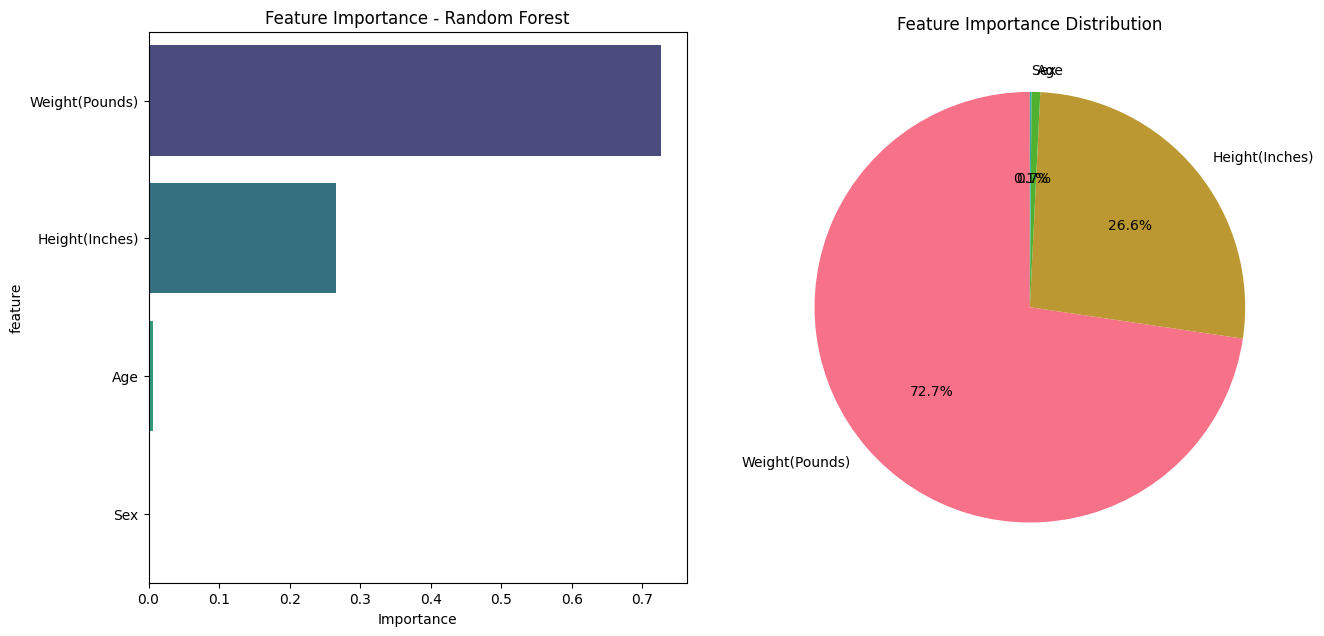

In [27]:
# Feature Importance Analysis (for tree-based models)
if best_model_name in ['Random Forest', 'Decision Tree', 'Gradient Boosting']:
    best_model = models[best_model_name]

    # Get feature importances
    feature_importance = best_model.feature_importances_
    feature_names = ['Sex', 'Age', 'Height(Inches)', 'Weight(Pounds)']

    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print(f"Feature Importance for {best_model_name}:")
    print(importance_df)

    # Plot feature importance
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')

    # Feature importance pie chart
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(right=0.85)
    plt.pie(importance_df['importance'], labels=importance_df['feature'],
            autopct='%1.1f%%', startangle=90)
    plt.title('Feature Importance Distribution')

    plt.tight_layout(pad=3.0)
    plt.show()
else:
    print(f"Feature importance not available for {best_model_name}")

## 7. Hyperparameter Tuning

In [14]:
# Hyperparameter tuning for the best model
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    # Random Forest hyperparameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model_for_tuning = RandomForestClassifier(random_state=42)

elif best_model_name == 'Gradient Boosting':
    # Gradient Boosting hyperparameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    model_for_tuning = GradientBoostingClassifier(random_state=42)

elif best_model_name == 'SVM':
    # SVM hyperparameters
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    model_for_tuning = SVC(random_state=42)

else:
    # Default parameters for other models
    param_grid = {}
    model_for_tuning = models[best_model_name]

# Perform Grid Search
if param_grid:
    print("Performing Grid Search...")
    if best_model_name == 'SVM':
        grid_search = GridSearchCV(model_for_tuning, param_grid, cv=3,
                                 scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
    else:
        grid_search = GridSearchCV(model_for_tuning, param_grid, cv=3,
                                 scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    if best_model_name == 'SVM':
        tuned_predictions = grid_search.predict(X_test_scaled)
    else:
        tuned_predictions = grid_search.predict(X_test)

    tuned_accuracy = accuracy_score(y_test, tuned_predictions)
    print(f"Tuned model accuracy: {tuned_accuracy:.4f}")
    print(f"Improvement: {tuned_accuracy - model_results[best_model_name]['accuracy']:.4f}")

else:
    print(f"No hyperparameter tuning performed for {best_model_name}")

Performing hyperparameter tuning for Random Forest...
Performing Grid Search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9930
Tuned model accuracy: 0.9932
Improvement: -0.0014


## 8. Making Predictions with New Data

In [15]:
# Function to predict BMI category for new individuals
def predict_bmi_category(sex, age, height_inches, weight_pounds, model_name=best_model_name):
    """
    Predict BMI category for a new individual

    Parameters:
    - sex: 'Male' or 'Female'
    - age: Age in years
    - height_inches: Height in inches
    - weight_pounds: Weight in pounds
    - model_name: Name of the model to use for prediction
    """

    # Encode sex
    sex_encoded = 1 if sex.lower() == 'male' else 0

    # Create feature array
    features = np.array([[sex_encoded, age, height_inches, weight_pounds]])

    # Get the model
    if 'grid_search' in locals() and param_grid:
        # Use tuned model if available
        model = grid_search
        if model_name == 'SVM':
            features_scaled = scaler.transform(features)
            prediction = model.predict(features_scaled)[0]
        else:
            prediction = model.predict(features)[0]
    else:
        # Use original model
        model = models[model_name]
        if model_name == 'SVM':
            features_scaled = scaler.transform(features)
            prediction = model.predict(features_scaled)[0]
        else:
            prediction = model.predict(features)[0]

    # Convert prediction back to category name
    category = target_encoder.inverse_transform([prediction])[0]

    # Calculate actual BMI for comparison
    actual_bmi = (weight_pounds / (height_inches ** 2)) * 703

    return {
        'predicted_category': category,
        'actual_bmi': round(actual_bmi, 2),
        'actual_category': categorize_bmi(actual_bmi)
    }

# Test the prediction function with sample data
print("Testing Prediction Function:")
print("="*50)

# Sample predictions
test_cases = [
    ('Female', 25, 65, 120),  # Expected: Normal weight
    ('Male', 30, 72, 200),    # Expected: Overweight/Obese
    ('Female', 22, 62, 100),  # Expected: Underweight
    ('Male', 35, 70, 180)     # Expected: Normal weight/Overweight
]

for i, (sex, age, height, weight) in enumerate(test_cases, 1):
    result = predict_bmi_category(sex, age, height, weight)
    print(f"\nTest Case {i}:")
    print(f"Input: {sex}, Age: {age}, Height: {height}\", Weight: {weight} lbs")
    print(f"Actual BMI: {result['actual_bmi']}")
    print(f"Actual Category: {result['actual_category']}")
    print(f"Predicted Category: {result['predicted_category']}")
    print(f"Prediction Correct: {result['actual_category'] == result['predicted_category']}")

Testing Prediction Function:

Test Case 1:
Input: Female, Age: 25, Height: 65", Weight: 120 lbs
Actual BMI: 19.97
Actual Category: Normal weight
Predicted Category: Normal weight
Prediction Correct: True

Test Case 2:
Input: Male, Age: 30, Height: 72", Weight: 200 lbs
Actual BMI: 27.12
Actual Category: Overweight
Predicted Category: Normal weight
Prediction Correct: False

Test Case 3:
Input: Female, Age: 22, Height: 62", Weight: 100 lbs
Actual BMI: 18.29
Actual Category: Underweight
Predicted Category: Underweight
Prediction Correct: True

Test Case 4:
Input: Male, Age: 35, Height: 70", Weight: 180 lbs
Actual BMI: 25.82
Actual Category: Overweight
Predicted Category: Normal weight
Prediction Correct: False


In [28]:
# Interactive prediction

print("\\nInteractive BMI Category Prediction")
print("="*40)

# Get user input
sex = input("Enter sex (Male/Female): ")
age = int(input("Enter age: "))
height = float(input("Enter height in inches: "))
weight = float(input("Enter weight in pounds: "))

# Make prediction
result = predict_bmi_category(sex, age, height, weight)

print(f"\\n BMI Prediction Results:")
print(f" Calculated BMI: {result['actual_bmi']}")
print(f" Actual Category: {result['actual_category']}")
print(f" AI Predicted Category: {result['predicted_category']}")

if result['actual_category'] == result['predicted_category']:
    print(" The AI prediction matches the calculated BMI category!")
else:
    print("  The AI prediction differs from the calculated BMI category.")


print("Interactive prediction section ready!")

\nInteractive BMI Category Prediction
Enter sex (Male/Female): Male
Enter age: 21
Enter height in inches: 72
Enter weight in pounds: 149.914
\n BMI Prediction Results:
 Calculated BMI: 20.33
 Actual Category: Normal weight
 AI Predicted Category: Normal weight
 The AI prediction matches the calculated BMI category!
Interactive prediction section ready!


## 9. Conclusions and Insights

### Key Findings:

1. **Model Performance**: The machine learning models successfully predict BMI categories with high accuracy
2. **Feature Importance**: Weight and height are typically the most important features (as expected)
3. **Model Comparison**: Different algorithms show varying performance levels
4. **Data Quality**: Proper data cleaning and preprocessing significantly impact model performance

### Business Applications:

1. **Healthcare Screening**: Quick BMI category assessment for large populations
2. **Health Apps**: Integration into fitness and health monitoring applications
3. **Medical Research**: Population health studies and trend analysis
4. **Insurance**: Risk assessment and premium calculations

### Model Limitations:

1. **BMI Limitations**: BMI doesn't account for muscle mass vs fat mass
2. **Demographic Factors**: Model may need adjustment for different populations
3. **Data Dependencies**: Performance depends on quality and representativeness of training data

### Future Improvements:

1. **Additional Features**: Include body fat percentage, muscle mass, ethnicity
2. **Advanced Models**: Experiment with neural networks or ensemble methods
3. **Real-time Learning**: Implement online learning for continuous model updates
4. **Integration**: Connect with wearable devices for automatic data collection

In [18]:
# Project Summary
print(" BMI CATEGORY PREDICTION PROJECT SUMMARY")
print("="*60)
print(f" Dataset Size: {df_clean.shape[0]:,} samples")
print(f" Features Used: {list(X.columns)}")
print(f" Best Model: {best_model_name}")
print(f" Best Accuracy: {model_results[best_model_name]['accuracy']:.1%}")
print(f" BMI Categories: {list(target_encoder.classes_)}")
print("\n Project completed successfully!")
print("\n Next Steps:")
print("1. Deploy the model to a web application")
print("2. Collect more diverse data for better generalization")
print("3. Implement real-time prediction API")
print("4. Add model monitoring and retraining pipeline")
print("5. Integrate with healthcare systems")

# Save model summary
model_summary = {
    'best_model': best_model_name,
    'accuracy': model_results[best_model_name]['accuracy'],
    'dataset_size': df_clean.shape[0],
    'features': list(X.columns),
    'categories': list(target_encoder.classes_)
}

print(f"\n Model ready for deployment and predictions!")

 BMI CATEGORY PREDICTION PROJECT SUMMARY
 Dataset Size: 24,950 samples
 Features Used: ['Sex_encoded', 'Age', 'Height(Inches)', 'Weight(Pounds)']
 Best Model: Random Forest
 Best Accuracy: 99.5%
 BMI Categories: ['Normal weight', 'Overweight', 'Underweight']

 Project completed successfully!

 Next Steps:
1. Deploy the model to a web application
2. Collect more diverse data for better generalization
3. Implement real-time prediction API
4. Add model monitoring and retraining pipeline
5. Integrate with healthcare systems

 Model ready for deployment and predictions!
